In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
import folium
from folium.plugins import MarkerCluster
from dataste_read import read_protest_and_riots_conflict_related

In [4]:
riots_and_protests_US = pd.read_csv('data/riots_and_protests_US.csv')
riots_and_protests_US['event_date'] = pd.to_datetime(riots_and_protests_US['event_date'])

oct7_date = pd.to_datetime('2023-10-07')
riots_and_protests_US['post_oct7'] = riots_and_protests_US['event_date'] >= oct7_date

# Check the shape of the data
print(f"Total number of events: {riots_and_protests_US.shape[0]}")
print(f"Events before October 7, 2023: {(~riots_and_protests_US['post_oct7']).sum()}")
print(f"Events after October 7, 2023: {riots_and_protests_US['post_oct7'].sum()}")

Total number of events: 6235
Events before October 7, 2023: 1014
Events after October 7, 2023: 5221


In [ ]:
# show number of events over time
riots_and_protests_US['event_date'] = pd.to_datetime(riots_and_protests_US['event_date'])

riots_and_protests_US['month'] = riots_and_protests_US['event_date'].dt.to_period('M')


monthly_counts = riots_and_protests_US.groupby('month').size().reset_index(name='count')


monthly_counts['month'] = monthly_counts['month'].dt.to_timestamp()


fig = px.line(
    monthly_counts, 
    x='month', 
    y='count', 
    title='Number of Israeli Palestinian Conflict Related Protests and Riots in the US (monthly)',
    labels={'month': 'Month', 'count': 'Number of Protests and Riots'}
)

fig.add_vline(
    x="2023-10-01", 
    line_width=2, line_dash="dash", line_color="red"
)
fig.add_vline(
    x="2021-05-01", 
    line_width=2, line_dash="dash", line_color="blue"
)

max_count = monthly_counts['count'].max()

fig.add_annotation(
    x="2023-10-01",
    y=max_count,
    text="October-7 (2023)",
    showarrow=True,
    arrowhead=1,
    ax=0,
    ay=-40, 
    xanchor="left"
)

fig.add_annotation(
    x="2021-05-01",
    y=max_count,
    text="Operation Guardian of the Walls",
    showarrow=True,
    arrowhead=1,
    ax=0,
    ay=-40,  
    xanchor="left"
)

fig.show()


# General Conflict Analisis

In [10]:
from additional_code.data_clean import read_and_clean_data
import pandas as pd

In [11]:
dfs = read_and_clean_data()
dfs.keys()

dict_keys(['battles', 'explotions_or_remote_violence', 'violence_against_civilians', 'riots', 'protests', 'riots_US', 'protests_US'])

In [12]:
dfs['explotions_or_remote_violence']['actor1'].value_counts().describe()

count     1878.000000
mean       101.165602
std       1018.374266
min          1.000000
25%          1.000000
50%          2.000000
75%          7.000000
max      25289.000000
Name: count, dtype: float64

Map has been created as 'battles_world_map.html'
Additional visualizations saved as PNG files


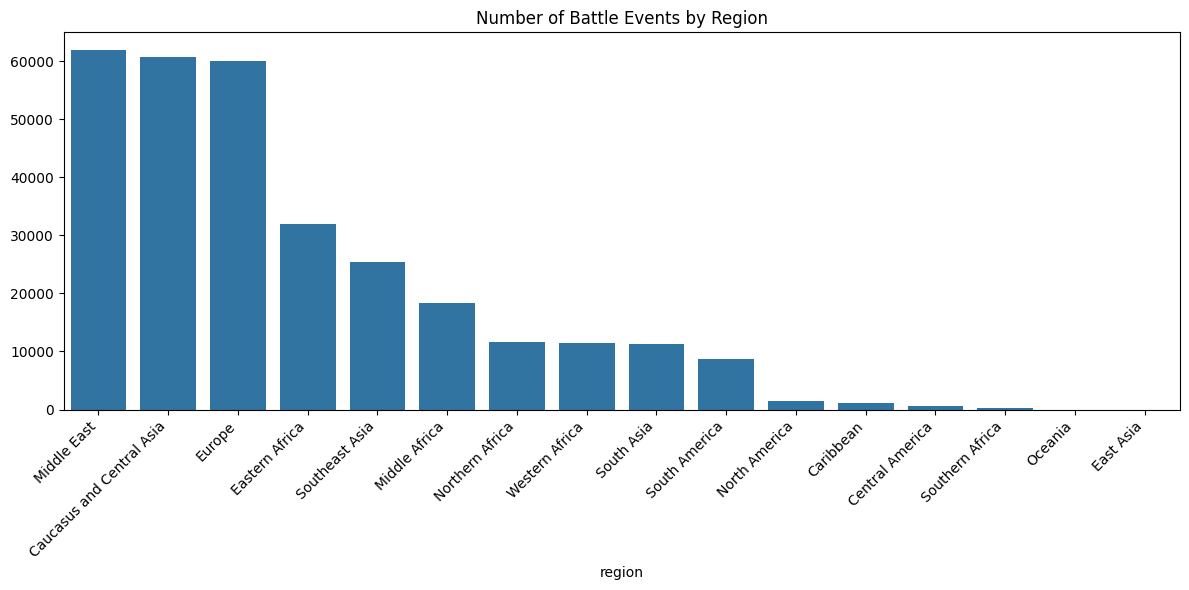

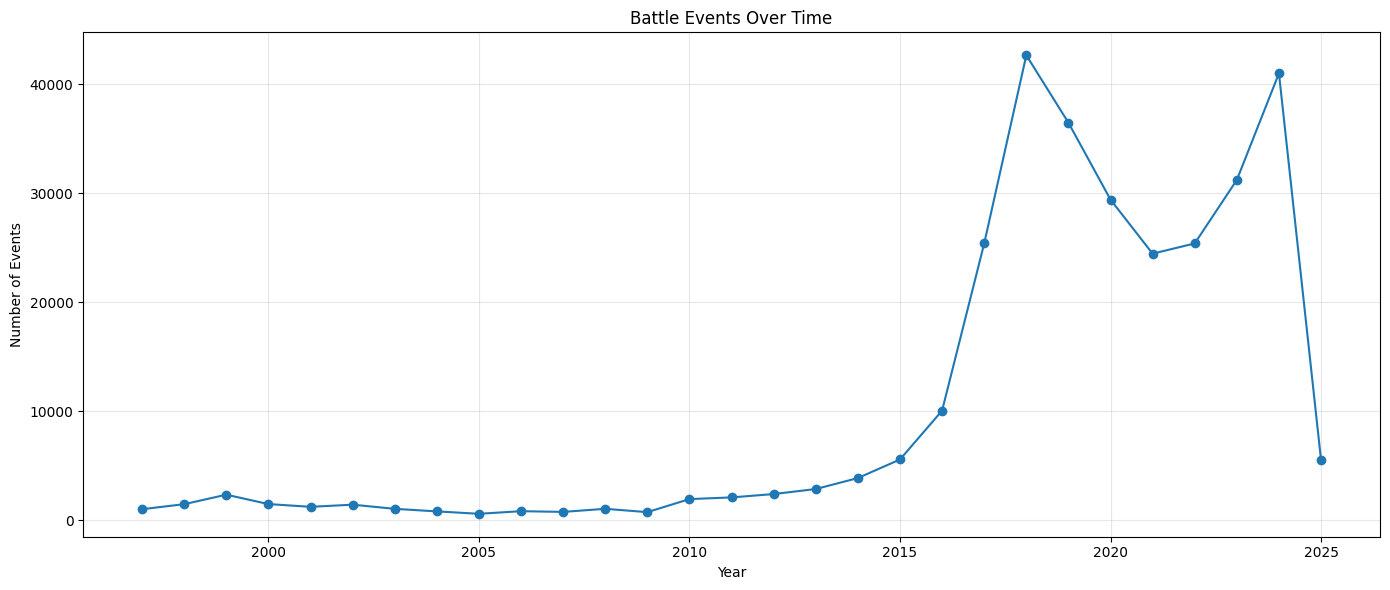

In [15]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the dataset
# Replace 'your_battles_dataset.csv' with your actual file name
df = dfs['battles']

# Clean the data
# Convert date to datetime
df['event_date'] = pd.to_datetime(df['event_date'], errors='coerce')

# Drop rows with missing latitude or longitude
df = df.dropna(subset=['latitude', 'longitude'])

# If the 'location' column is missing or has nulls, create a location string from latitude and longitude
if 'location' not in df.columns or df['location'].isna().all():
    df['location'] = df.apply(lambda row: f"({row['latitude']:.3f}, {row['longitude']:.3f})", axis=1)
else:
    # Optionally, for rows with missing location names, fill them with coordinates
    df['location'] = df.apply(lambda row: row['location'] if pd.notna(row['location']) 
                              else f"({row['latitude']:.3f}, {row['longitude']:.3f})", axis=1)

# Create a world map centered at (0, 0) with initial zoom level 2
world_map = folium.Map(location=[0, 0], zoom_start=2, tiles='CartoDB positron')

# Create a marker cluster to improve performance with many points
marker_cluster = MarkerCluster().add_to(world_map)

# Determine fatality scale for marker size
max_fatalities = df['fatalities'].max()

# Add markers for each battle
for idx, row in df.iterrows():
    # Skip if we don't have geo data (should be redundant after dropna)
    if pd.isna(row['latitude']) or pd.isna(row['longitude']):
        continue
    
    # Calculate marker size based on fatalities (with a minimum size)
    fatality_size = 5
    if pd.notna(row['fatalities']) and max_fatalities > 0:
        fatality_size = 5 + (row['fatalities'] / max_fatalities) * 15
    
    # Create popup text with event details, including coordinates
    popup_text = f"""
    <b>Location:</b> {row['location']}, {row.get('country', 'N/A')}<br>
    <b>Coordinates:</b> {row['latitude']:.3f}, {row['longitude']:.3f}<br>
    <b>Date:</b> {row['event_date'].date()}<br>
    <b>Type:</b> {row['event_type']}<br>
    <b>Actors:</b> {row['actor1']} vs {row['actor2']}<br>
    <b>Fatalities:</b> {row['fatalities']}<br>
    <b>Notes:</b> {row['notes']}
    """
    
    # Determine color based on event_type
    event_colors = {
        'Battle': 'red',
        'Violence against civilians': 'black',
        'Riots': 'orange',
        'Protests': 'blue',
        'Strategic developments': 'green'
    }
    # Default color if event_type is not in our dictionary
    color = event_colors.get(row['event_type'], 'gray')
    
    # Add marker to the cluster
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=fatality_size,
        popup=folium.Popup(popup_text, max_width=300),
        tooltip=f"{row['location']}: {row['event_type']}",
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7
    ).add_to(marker_cluster)

# Add a legend
legend_html = '''
<div style="position: fixed; 
     bottom: 50px; right: 50px; width: 150px; height: 160px; 
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white; padding: 10px">
     &nbsp; <b>Event Types</b> <br>
     &nbsp; <i class="fa fa-circle" style="color:red"></i> &nbsp; Battle <br>
     &nbsp; <i class="fa fa-circle" style="color:black"></i> &nbsp; Violence against civilians<br>
     &nbsp; <i class="fa fa-circle" style="color:orange"></i> &nbsp; Riots<br>
     &nbsp; <i class="fa fa-circle" style="color:blue"></i> &nbsp; Protests<br>
     &nbsp; <i class="fa fa-circle" style="color:green"></i> &nbsp; Strategic developments<br>
     &nbsp; <i class="fa fa-circle" style="color:gray"></i> &nbsp; Other<br>
     <span style="font-size: 10px">(Circle size indicates fatalities)</span>
</div>
'''
world_map.get_root().html.add_child(folium.Element(legend_html))

# Save the map
world_map.save('battles_world_map.html')

# Additional visualizations

# Events by region barplot
plt.figure(figsize=(12, 6))
region_counts = df['region'].value_counts().sort_values(ascending=False)
sns.barplot(x=region_counts.index, y=region_counts.values)
plt.title('Number of Battle Events by Region')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('battles_by_region.png')

# Events over time line plot
plt.figure(figsize=(14, 6))
df_time = df.groupby(df['event_date'].dt.year).size()
plt.plot(df_time.index, df_time.values, marker='o', linestyle='-')
plt.title('Battle Events Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Events')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('battles_over_time.png')

print("Map has been created as 'battles_world_map.html'")
print("Additional visualizations saved as PNG files")


In [16]:
dfs['battles']['interaction'].value_counts()

interaction
State forces-Rebel group                       149565
State forces-External/Other forces              50866
State forces-Political militia                  33599
State forces-State forces                       30231
Rebel group-Rebel group                         11000
Rebel group-External/Other forces               10480
Political militia-Political militia              7417
Rebel group-Political militia                    7222
Political militia-External/Other forces          4245
External/Other forces-External/Other forces       146
Name: count, dtype: int64

In [17]:
from collections import defaultdict
def calculate_actor_coordinates(battles_df, actor_list):
    # Dictionary to store all coordinates for each actor
    actor_coords = defaultdict(list)
    
    # Iterate through battles
    for _, battle in battles_df.iterrows():
        # Check actor1
        if battle['actor1'] in actor_list:
            actor_coords[battle['actor1']].append((battle['latitude'], battle['longitude']))
        
        # Check actor2
        if battle['actor2'] in actor_list:
            actor_coords[battle['actor2']].append((battle['latitude'], battle['longitude']))
    
    # Calculate mean coordinates for each actor
    actor_mean_coords = {}
    for actor, coords in actor_coords.items():
        if coords:  # Ensure there are coordinates
            lats, lngs = zip(*coords)
            actor_mean_coords[actor] = (np.mean(lats), np.mean(lngs))
    
    # Convert to DataFrame
    coords_df = pd.DataFrame([(actor, lat, lng, len(actor_coords[actor])) 
                              for actor, (lat, lng) in actor_mean_coords.items()], 
                             columns=['actor', 'latitude', 'longitude', 'battle_count'])
    
    return coords_df

In [21]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import requests
import io
import contextily as ctx
from shapely.geometry import Point

def plot_actor_map(actor_coords_df):
    """
    Plot actors on a world map with the size and color of points representing battle counts.
    
    Parameters:
    actor_coords_df (pandas.DataFrame): DataFrame with columns 'actor', 'latitude', 'longitude', and 'battle_count'
    
    Returns:
    tuple: (fig, ax) matplotlib figure and axis objects
    """
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Download Natural Earth data directly
    url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
    try:
        response = requests.get(url)
        world_map = gpd.read_file(io.BytesIO(response.content))
    except Exception as e:
        print(f"Failed to download world map data: {e}")
        # Create a simple box as fallback
        world_map = gpd.GeoDataFrame(
            geometry=[Point(0, 0).buffer(180)], 
            crs="EPSG:4326"
        )
    
    # Plot the world map as background
    world_map.plot(ax=ax, color='lightgray', edgecolor='dimgray', linewidth=0.5)
    
    # Set up the axes for a world map
    ax.set_xlim([-180, 180])
    ax.set_ylim([-90, 90])
    ax.grid(True, linestyle='--', alpha=0.5)
    
    # Use a colormap based on battle count
    min_battles = actor_coords_df['battle_count'].min()
    max_battles = actor_coords_df['battle_count'].max()
    
    # Use log scale for better visualization
    sizes = np.log2(actor_coords_df['battle_count'] * 20)
    colors = np.log2(actor_coords_df['battle_count'])
    
    # Plot each actor as a point
    scatter = ax.scatter(
        actor_coords_df['longitude'], 
        actor_coords_df['latitude'],
        c=colors,
        cmap=plt.cm.viridis,
        s=sizes,  # Size relative to battle count
        alpha=0.7,
        edgecolor='black'
    )
    
    # Add a colorbar to show battle count scale
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Log₂(Number of Battles)')
    
    # Label some of the major actors (top 10)
    top_actors = actor_coords_df.sort_values('battle_count', ascending=False).head(10)
    for _, actor in top_actors.iterrows():
        ax.annotate(
            actor['actor'],
            xy=(actor['longitude'], actor['latitude']),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=8,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7)
        )
    
    # Try to add contextily basemap if available
    try:
        ctx.add_basemap(
            ax, 
            crs=actor_coords_df.crs if hasattr(actor_coords_df, 'crs') else "EPSG:4326",
            source=ctx.providers.CartoDB.Positron
        )
    except Exception as e:
        print(f"Unable to add contextily basemap: {e}")
    
    plt.title('Actor Locations Based on Average Battle Coordinates')
    plt.tight_layout()
    
    return fig, ax

Unable to add contextily basemap: Read or write failed. GDALWarperOperation::ComputeSourceWindow() failed because the pfnTransformer failed.


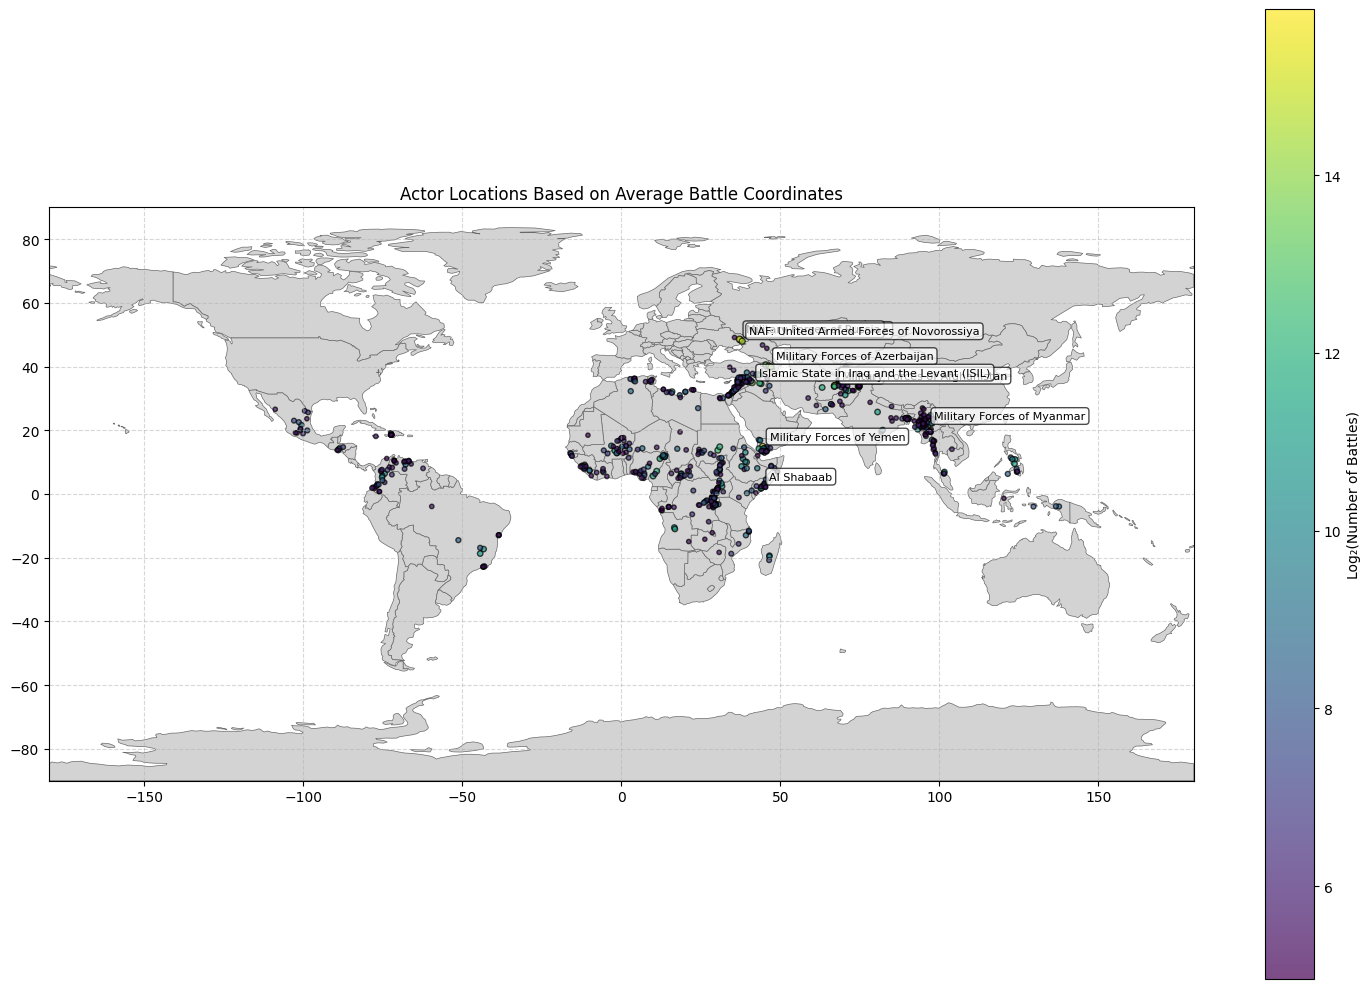

In [22]:
from collections import Counter
import matplotlib.pyplot as plt

actors = dfs['battles']['actor1'].tolist() + dfs['battles']['actor2'].tolist()
actors_count = Counter(actors)
result_df = pd.DataFrame({'actor': list(actors_count.keys()), 
                            'count': list(actors_count.values())})
result_df = result_df.sort_values('count', ascending=False).reset_index(drop=True)
actors_appear_more_than_30_times = result_df[result_df['count']> 30]['actor'].to_list()

battels_conflicts = dfs['battles'][(dfs['battles']['actor1'].isin(actors_appear_more_than_30_times)) | (dfs['battles']['actor2'].isin(actors_appear_more_than_30_times))].reset_index(drop=True)
actor_coordinates = calculate_actor_coordinates(battels_conflicts, actors_appear_more_than_30_times)


fig, ax = plot_actor_map(actor_coordinates)
plt.show()

In [23]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import requests
import io
import contextily as ctx
from shapely.geometry import Point
import matplotlib.patches as patches
import matplotlib.lines as mlines

def plot_actor_map_with_links(actor_coords_df, battles_df, actor_column1='actor1', actor_column2='actor2', max_links=100):
    """
    Plot actors on a world map with the size and color of points representing battle counts,
    and add directional links between actors who fought each other.
    
    Parameters:
    actor_coords_df (pandas.DataFrame): DataFrame with columns 'actor', 'latitude', 'longitude', and 'battle_count'
    battles_df (pandas.DataFrame): DataFrame with battles data, including actor1 and actor2 columns
    actor_column1 (str): Name of the first actor column in battles_df
    actor_column2 (str): Name of the second actor column in battles_df
    max_links (int): Maximum number of links to draw to avoid overcrowding
    
    Returns:
    tuple: (fig, ax) matplotlib figure and axis objects
    """
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Download Natural Earth data directly
    url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
    try:
        response = requests.get(url)
        world_map = gpd.read_file(io.BytesIO(response.content))
    except Exception as e:
        print(f"Failed to download world map data: {e}")
        # Create a simple box as fallback
        world_map = gpd.GeoDataFrame(
            geometry=[Point(0, 0).buffer(180)], 
            crs="EPSG:4326"
        )
    
    # Plot the world map as background
    world_map.plot(ax=ax, color='lightgray', edgecolor='dimgray', linewidth=0.5)
    
    # Set up the axes for a world map
    ax.set_xlim([-180, 180])
    ax.set_ylim([-90, 90])
    ax.grid(True, linestyle='--', alpha=0.5)
    
    # Create a lookup dictionary for actor coordinates
    actor_lookup = actor_coords_df.set_index('actor')[['latitude', 'longitude']].to_dict('index')
    
    # Count battle frequency between each pair of actors
    battle_pairs = []
    for _, row in battles_df.iterrows():
        actor1 = row[actor_column1]
        actor2 = row[actor_column2]
        if actor1 in actor_lookup and actor2 in actor_lookup:
            battle_pairs.append((actor1, actor2))
    
    # Count frequency of each battle pair
    from collections import Counter
    pair_counts = Counter(battle_pairs)
    
    # Get the most frequent battle pairs (to avoid cluttering the map)
    top_pairs = pair_counts.most_common(max_links)
    
    # Add arrows for the most frequent battle pairs
    for (actor1, actor2), count in top_pairs:
        if actor1 in actor_lookup and actor2 in actor_lookup:
            start_lat, start_lon = actor_lookup[actor1]['latitude'], actor_lookup[actor1]['longitude']
            end_lat, end_lon = actor_lookup[actor2]['latitude'], actor_lookup[actor2]['longitude']
            
            # Skip if start and end are too close
            if abs(start_lat - end_lat) < 0.1 and abs(start_lon - end_lon) < 0.1:
                continue
                
            # Handle crossing the international date line
            if abs(start_lon - end_lon) > 180:
                # This connection crosses the date line, skip it for simplicity
                continue
            
            # Calculate the arrow attributes based on battle count
            width = 0.5 + np.log2(count) * 0.2  # Width based on battle count
            alpha = min(0.6, 0.3 + np.log2(count) * 0.05)  # Opacity based on battle count
            
            # Draw a curved arrow between the points
            # Create an arc path 
            dx = end_lon - start_lon
            dy = end_lat - start_lat
            
            # Create arrow
            arrow = patches.FancyArrowPatch(
                (start_lon, start_lat),
                (end_lon, end_lat),
                connectionstyle=f"arc3,rad={0.2}",
                arrowstyle="->",
                color="red",
                alpha=alpha,
                linewidth=width,
                mutation_scale=10
            )
            ax.add_patch(arrow)
    
    # Use a colormap based on battle count
    min_battles = actor_coords_df['battle_count'].min()
    max_battles = actor_coords_df['battle_count'].max()
    
    # Use log scale for better visualization
    sizes = np.log2(actor_coords_df['battle_count'] * 5)
    colors = np.log2(actor_coords_df['battle_count'])
    
    # Plot each actor as a point
    scatter = ax.scatter(
        actor_coords_df['longitude'], 
        actor_coords_df['latitude'],
        c=colors,
        cmap=plt.cm.viridis,
        s=sizes,  # Size relative to battle count
        alpha=0.7,
        edgecolor='black',
        zorder=100  # To ensure points are drawn on top of arrows
    )
    
    # Add a colorbar to show battle count scale
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Log₂(Number of Battles)')
    
    # Label some of the major actors (top 10)
    top_actors = actor_coords_df.sort_values('battle_count', ascending=False).head(10)
    for _, actor in top_actors.iterrows():
        ax.annotate(
            actor['actor'],
            xy=(actor['longitude'], actor['latitude']),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=8,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7),
            zorder=101  # Ensure labels are on top
        )
    
    # Add legend for arrows
    arrow_legend = mlines.Line2D([], [], color='red', marker='>', linestyle='-',
                          markersize=10, label='Conflict Direction')
    plt.legend(handles=[arrow_legend], loc='lower right')
    
    plt.title('Actor Locations and Conflict Networks')
    plt.tight_layout()
    
    return fig, ax

def calculate_actor_coordinates_with_links(battles_df, actors_list, actor_column1='actor1', actor_column2='actor2', 
                                         lat_column='latitude', lon_column='longitude'):
    """
    Calculate the average coordinates for each actor based on battle locations
    and count the number of battles each actor was involved in.
    
    Parameters:
    battles_df (pandas.DataFrame): DataFrame with battles data
    actors_list (list): List of actor names to include
    actor_column1 (str): Name of the first actor column
    actor_column2 (str): Name of the second actor column
    lat_column (str): Name of the latitude column
    lon_column (str): Name of the longitude column
    
    Returns:
    pandas.DataFrame: DataFrame with actor coordinates and battle counts
    """
    actor_data = {}
    
    # Process each battle
    for _, battle in battles_df.iterrows():
        actor1 = battle[actor_column1]
        actor2 = battle[actor_column2]
        lat = battle[lat_column]
        lon = battle[lon_column]
        
        # Skip if coordinates are missing
        if pd.isna(lat) or pd.isna(lon):
            continue
        
        # Process actor1
        if actor1 in actors_list:
            if actor1 not in actor_data:
                actor_data[actor1] = {'lat_sum': 0, 'lon_sum': 0, 'count': 0}
            actor_data[actor1]['lat_sum'] += lat
            actor_data[actor1]['lon_sum'] += lon
            actor_data[actor1]['count'] += 1
        
        # Process actor2
        if actor2 in actors_list:
            if actor2 not in actor_data:
                actor_data[actor2] = {'lat_sum': 0, 'lon_sum': 0, 'count': 0}
            actor_data[actor2]['lat_sum'] += lat
            actor_data[actor2]['lon_sum'] += lon
            actor_data[actor2]['count'] += 1
    
    # Create result DataFrame
    result = []
    for actor, data in actor_data.items():
        if data['count'] > 0:
            result.append({
                'actor': actor,
                'latitude': data['lat_sum'] / data['count'],
                'longitude': data['lon_sum'] / data['count'],
                'battle_count': data['count']
            })
    
    return pd.DataFrame(result)


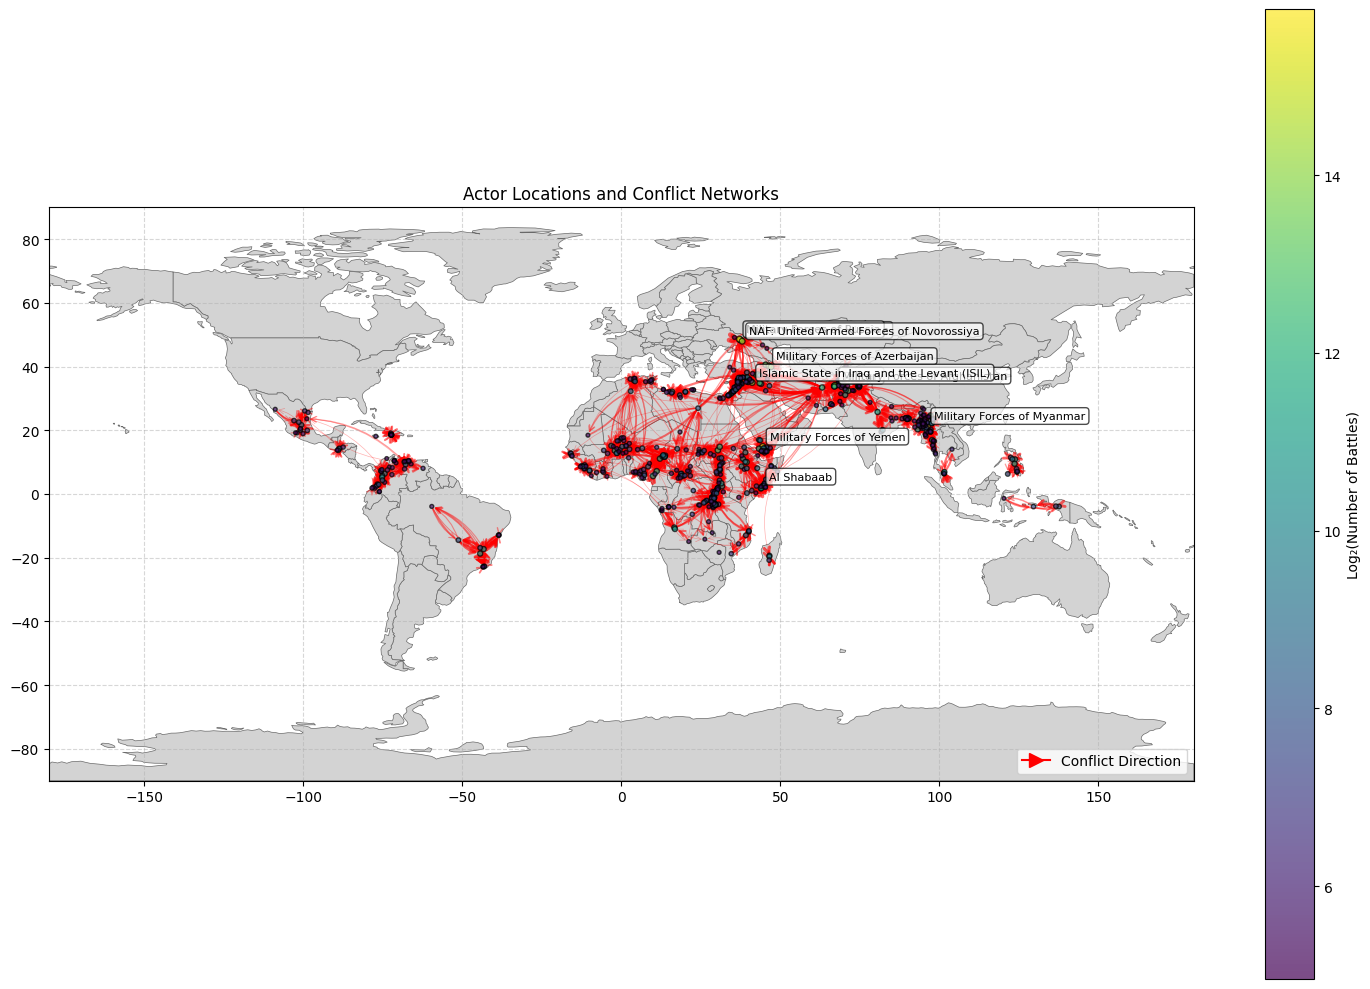

In [24]:
from collections import Counter
import matplotlib.pyplot as plt

# Your existing code to prepare the data
actors = dfs['battles']['actor1'].tolist() + dfs['battles']['actor2'].tolist()
actors_count = Counter(actors)
result_df = pd.DataFrame({'actor': list(actors_count.keys()), 
                          'count': list(actors_count.values())})
result_df = result_df.sort_values('count', ascending=False).reset_index(drop=True)
actors_appear_more_than_30_times = result_df[result_df['count'] > 30]['actor'].to_list()

battels_conflicts = dfs['battles'][(dfs['battles']['actor1'].isin(actors_appear_more_than_30_times)) | 
                                  (dfs['battles']['actor2'].isin(actors_appear_more_than_30_times))].reset_index(drop=True)

# Use the original actor coordinates you already calculated
actor_coordinates = calculate_actor_coordinates(battels_conflicts, actors_appear_more_than_30_times)

# Now use the new function to plot with directional links
fig, ax = plot_actor_map_with_links(
    actor_coords_df=actor_coordinates,
    battles_df=battels_conflicts,
    actor_column1='actor1',
    actor_column2='actor2',
    max_links=50000  # Limit to top 50 most frequent battle pairs to avoid clutter
)
plt.show()

# Israeli-Palestine Conflict Related data

This section is analizing the data annotated by the finetuned roberta model.

In [55]:
from additional_code.read_spesific_data import read_annotated_protests_and_riots, read_conflict_reports
annotated_protests_and_riots = read_annotated_protests_and_riots()
df_reports = read_conflict_reports()
df_reports.head()

c:\Users\omerg\Desktop\BigDataMiningProject\additional_code\read_spesific_data.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,event_id_cnty,event_date,year,disorder_type,event_type,sub_event_type,actor1,assoc_actor_1,inter1,actor2,...,region,country,admin1,latitude,longitude,source,source_scale,notes,fatalities,year_month
0,PSE67506,2025-02-14,2025,Political violence,Battles,Armed clash,Al Aqsa Martyrs Brigade,PIJ: Katibat Askar,Political militia,Military Forces of Israel,...,Middle East,Palestine,West Bank,32.2205,35.2982,Al Saraya Dafa; Hamas War Media; Newpress,New media-National,"On 14 February 2025, Al Aqsa Martyrs Brigade a...",0,2025-02
1,PSE67509,2025-02-13,2025,Political violence,Battles,Armed clash,Hamas Movement,NaN,Political militia,Military Forces of Israel,...,Middle East,Palestine,West Bank,32.4605,35.2882,Hamas War Media,New media,"On 13 February 2025, Hamas militants exchanged...",0,2025-02
2,PSE67631,2025-02-13,2025,Political violence,Battles,Armed clash,PIJ: Katibat Tulkarm,Al Aqsa Martyrs Brigade,Political militia,Military Forces of Israel,...,Middle East,Palestine,West Bank,32.3167,35.0667,Newpress,National,"On 13 February 2025, Katibat Tulkarm (PIJ) and...",0,2025-02
3,PSE67632,2025-02-13,2025,Political violence,Battles,Armed clash,PIJ: Katibat Tulkarm,NaN,Political militia,Military Forces of Israel,...,Middle East,Palestine,West Bank,32.3184,35.0592,Ma'an News Agency,National,"On 13 February 2025, Katibat Tulkarm (PIJ) exc...",0,2025-02
4,PSE67507,2025-02-12,2025,Political violence,Battles,Armed clash,Al Aqsa Martyrs Brigade,AAMB: Storm Brigade; AAMB: Tulkarm Youth of Re...,Political militia,Military Forces of Israel,...,Middle East,Palestine,West Bank,32.3167,35.0667,Al Ghad (Jordan); Haaretz; Israeli Defense For...,Other-National,"On 12 February 2025, Al Aqsa Martyrs Brigade, ...",2,2025-02


In [56]:
annotated_protests_and_riots.head()

,event_id_cnty,event_date,year,time_precision,disorder_type,event_type,sub_event_type,actor1,assoc_actor_1,inter1,...,fatalities,tags,timestamp,conflict_related,label,not_conflict_related,pro_israel,pro_palestine,antisemite,year_month
0,YEM96844,2025-02-14,2025,1,Demonstrations,Protests,Peaceful protest,Protesters (Yemen),Government of Yemen (2017-) Houthi; Women (Yemen),Protesters,...,0,crowd size=no report,1739832928,1,pro-Palestinian,0,0,1,0,2025-02
1,YEM96861,2025-02-14,2025,1,Demonstrations,Protests,Peaceful protest,Protesters (Yemen),Government of Yemen (2017-) Houthi,Protesters,...,0,crowd size=large,1739832928,1,pro-Palestinian,0,0,1,0,2025-02
2,YEM96866,2025-02-14,2025,1,Demonstrations,Protests,Peaceful protest,Protesters (Yemen),Government of Yemen (2017-) Houthi,Protesters,...,0,crowd size=large,1739832928,1,pro-Palestinian,0,0,1,0,2025-02
3,YEM96867,2025-02-14,2025,1,Demonstrations,Protests,Peaceful protest,Protesters (Yemen),Government of Yemen (2017-) Houthi,Protesters,...,0,crowd size=large,1739832928,1,pro-Palestinian,0,0,1,0,2025-02
4,YEM96872,2025-02-14,2025,1,Demonstrations,Protests,Peaceful protest,Protesters (Yemen),Government of Yemen (2017-) Houthi,Protesters,...,0,crowd size=large,1739832928,1,pro-Palestinian,0,0,1,0,2025-02


In [58]:
def filter_bigger_than_2020(df):
    df['event_date'] = pd.to_datetime(df['event_date'])
    return df[df['event_date'] > '2020-01-01']

In [77]:
# analizing the proportion of conflict related events and protests 
print(f"percentage of reports related to the conflict: {len(filter_bigger_than_2020(df_reports)) / (len(filter_bigger_than_2020(dfs['battles'])) + len(filter_bigger_than_2020(dfs['explotions_or_remote_violence']))):.2%}")
print(f"percentage of protests related to the conflict: {len(filter_bigger_than_2020(annotated_protests_and_riots[annotated_protests_and_riots['conflict_related'] == 1])) / (len(filter_bigger_than_2020(dfs['riots'])) + len(filter_bigger_than_2020(dfs['protests']))):.2%}")

percentage of reports related to the conflict: 4.50%
percentage of protests related to the conflict: 4.62%


In [39]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

df = annotated_protests_and_riots
monthly_battle_counts = df_reports.groupby('year_month').size().reset_index(name='count')
monthly_battle_counts['date'] = pd.to_datetime(monthly_battle_counts['year_month'] + '-01')


# filter data from 2020 onwards
df['date'] = pd.to_datetime(df['event_date'])
df = df[df['date'] >= pd.to_datetime("2020-01-01")]

# Extract year and month for grouping
df['year_month'] = df['date'].dt.strftime('%Y-%m')

# Count protests by type and month
monthly_counts = pd.DataFrame()

# Count pro-Israel protests
pro_israel_counts = df[df['pro_israel'] == 1].groupby('year_month').size().reset_index()
pro_israel_counts.columns = ['year_month', 'count']
pro_israel_counts['category'] = 'Pro-Israel'

# Count pro-Palestine protests
pro_palestine_counts = df[df['pro_palestine'] == 1].groupby('year_month').size().reset_index()
pro_palestine_counts.columns = ['year_month', 'count']
pro_palestine_counts['category'] = 'Pro-Palestine'


# Combine all counts
monthly_counts = pd.concat([pro_israel_counts, pro_palestine_counts])

# Convert year_month back to datetime for proper sorting
monthly_counts['date'] = pd.to_datetime(monthly_counts['year_month'] + '-01')
monthly_counts = monthly_counts.sort_values('date')


fig = make_subplots(rows=2, cols=1, 
                   subplot_titles=('Monthly US Conflict-Related Protests and riots (2020-Present)', 
                                  'Monthly Count of reports of Israeli Palestinian Conflict Related Events (2020-Present)'),
                   vertical_spacing=0.15)  # Add spacing between the plots

# Add the protest lines to the first subplot (top)
for category in monthly_counts['category'].unique():
    data = monthly_counts[monthly_counts['category'] == category]
    
    color = {
        'Pro-Israel': '#1F77B4',     # Blue
        'Pro-Palestine': '#2CA02C',  # Green
        'Antisemitic': '#D62728'     # Red
    }.get(category, '#FF7F0E')  # Default color if category not in map
    
    fig.add_trace(
        go.Scatter(
            x=data['date'], 
            y=data['count'], 
            name=category,
            mode='lines+markers',
            line=dict(color=color)
        ),
        row=1, col=1
    )

# Add the battle count line to the second subplot (bottom)
fig.add_trace(
    go.Scatter(
        x=monthly_battle_counts['date'], 
        y=monthly_battle_counts['count'],
        mode='lines+markers',
        name='Conflict Reports'
    ),
    row=2, col=1
)

# Update layout
fig.update_layout(
    height=800,  # Increase height to accommodate both plots
    width=900,
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
)

# Update x and y axis labels
fig.update_xaxes(title_text="Date", row=1, col=1)
fig.update_xaxes(title_text="Date", row=2, col=1)
fig.update_yaxes(title_text="Number of Protests/Events", row=1, col=1)
fig.update_yaxes(title_text="Number of Events (per month)", row=2, col=1)


fig.show()

In [40]:
fatalities_by_month = df_reports.groupby('year_month')['fatalities'].sum().reset_index()
fatalities_by_month.columns = ['year_month', 'total_fatalities']

protests_by_month = annotated_protests_and_riots[annotated_protests_and_riots['conflict_related'] == 1].groupby('year_month').size().reset_index()
protests_by_month.columns = ['year_month', 'protest_count']

combined_data = pd.merge(fatalities_by_month, protests_by_month, on='year_month', how='outer').fillna(0)

combined_data['year_month'] = pd.to_datetime(combined_data['year_month'])
combined_data = combined_data.sort_values('year_month')

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=combined_data['year_month'], y=combined_data['total_fatalities'], 
               name='Fatalities', line=dict(color='red')),
    secondary_y=False
)

fig.add_trace(
    go.Scatter(x=combined_data['year_month'], y=combined_data['protest_count'], 
               name='Protest Count', line=dict(color='blue')),
    secondary_y=True
)


fig.update_layout(
    title='Relationship Between Fatalities and Protest Activity Over Time',
    xaxis_title='Date',
    legend=dict(orientation='h', yanchor="bottom", y=1.02, xanchor="center", x=0.5)
)

fig.update_yaxes(title_text='Total reported Fatalities', secondary_y=False, color='red')
fig.update_yaxes(title_text='Number of Protests', secondary_y=True, color='blue')

fig.show()


correlation = combined_data['total_fatalities'].corr(combined_data['protest_count'])
print(f"Correlation between fatalities and protest count: {correlation:.3f}")


combined_data['fatalities_lag1'] = combined_data['total_fatalities'].shift(1)
lag_correlation = combined_data['fatalities_lag1'].corr(combined_data['protest_count'])
print(f"Correlation with 1-month lag: {lag_correlation:.3f}")


Correlation between fatalities and protest count: 0.870
Correlation with 1-month lag: 0.632


In [41]:
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Aggregate fatalities by month
fatalities_by_month = df_reports.groupby('year_month')['fatalities'].sum().reset_index()
fatalities_by_month.columns = ['year_month', 'total_fatalities']

# Aggregate protest counts by month for pro-Israel protests
protests_israel_by_month = annotated_protests_and_riots[
    (annotated_protests_and_riots['conflict_related'] == 1) & 
    (annotated_protests_and_riots['pro_israel'] == 1)
].groupby('year_month').size().reset_index(name='protest_count_israel')

# Aggregate protest counts by month for pro-Palestine protests
protests_palestine_by_month = annotated_protests_and_riots[
    (annotated_protests_and_riots['conflict_related'] == 1) & 
    (annotated_protests_and_riots['pro_palestine'] == 1)
].groupby('year_month').size().reset_index(name='protest_count_palestine')

# Merge the fatalities and both protest counts datasets
combined_data = pd.merge(fatalities_by_month, protests_israel_by_month, on='year_month', how='outer')
combined_data = pd.merge(combined_data, protests_palestine_by_month, on='year_month', how='outer').fillna(0)

# Convert 'year_month' to datetime and sort
combined_data['year_month'] = pd.to_datetime(combined_data['year_month'])
combined_data = combined_data.sort_values('year_month')

# Create dual-axis plot with Plotly. We'll plot fatalities on the primary y-axis,
# and both protest counts on the secondary y-axis.
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=combined_data['year_month'], y=combined_data['total_fatalities'], 
               name='Fatalities', line=dict(color='red')),
    secondary_y=False
)

fig.add_trace(
    go.Scatter(x=combined_data['year_month'], y=combined_data['protest_count_israel'], 
               name='Protest Count (Pro-Israel)', line=dict(color='blue')),
    secondary_y=True
)

fig.add_trace(
    go.Scatter(x=combined_data['year_month'], y=combined_data['protest_count_palestine'], 
               name='Protest Count (Pro-Palestine)', line=dict(color='green')),
    secondary_y=True
)

fig.update_layout(
    title='Relationship Between Fatalities and Protest Activity Over Time',
    xaxis_title='Date',
    legend=dict(orientation='h', yanchor="bottom", y=1.02, xanchor="center", x=0.5)
)

fig.update_yaxes(title_text='Total Reported Fatalities', secondary_y=False, color='red')
fig.update_yaxes(title_text='Number of Protests', secondary_y=True, color='blue')

fig.show()

# Calculate the correlation between fatalities and each protest count
correlation_israel = combined_data['total_fatalities'].corr(combined_data['protest_count_israel'])
print(f"Correlation between fatalities and protest count (Pro-Israel): {correlation_israel:.3f}")

correlation_palestine = combined_data['total_fatalities'].corr(combined_data['protest_count_palestine'])
print(f"Correlation between fatalities and protest count (Pro-Palestine): {correlation_palestine:.3f}")

# Compute one-month lag correlations
combined_data['fatalities_lag1'] = combined_data['total_fatalities'].shift(1)

lag_correlation_israel = combined_data['fatalities_lag1'].corr(combined_data['protest_count_israel'])
print(f"Correlation with 1-month lag (Pro-Israel): {lag_correlation_israel:.3f}")

lag_correlation_palestine = combined_data['fatalities_lag1'].corr(combined_data['protest_count_palestine'])
print(f"Correlation with 1-month lag (Pro-Palestine): {lag_correlation_palestine:.3f}")


Correlation between fatalities and protest count (Pro-Israel): 0.771
Correlation between fatalities and protest count (Pro-Palestine): 0.861
Correlation with 1-month lag (Pro-Israel): 0.237
Correlation with 1-month lag (Pro-Palestine): 0.644


In [42]:
# Aggregate fatalities by day using 'event_date'
fatalities_by_day = df_reports.groupby('event_date')['fatalities'].sum().reset_index()
fatalities_by_day.columns = ['event_date', 'total_fatalities']

# Aggregate protest counts by day for conflict-related protests using 'event_date'
protests_by_day = annotated_protests_and_riots[annotated_protests_and_riots['conflict_related'] == 1] \
    .groupby('event_date').size().reset_index()
protests_by_day.columns = ['event_date', 'protest_count']

# Merge the two datasets
combined_data_daily = pd.merge(fatalities_by_day, protests_by_day, on='event_date', how='outer').fillna(0)

# Convert event_date column to datetime and sort
combined_data_daily['event_date'] = pd.to_datetime(combined_data_daily['event_date'])
combined_data_daily = combined_data_daily.sort_values('event_date')

# Filter the data to include only records after October 7, 2023
combined_data_daily = combined_data_daily[combined_data_daily['event_date'] > pd.to_datetime('2023-10-07')]

# Create dual-axis plot with Plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add fatalities trace on the primary y-axis
fig.add_trace(
    go.Scatter(x=combined_data_daily['event_date'], y=combined_data_daily['total_fatalities'], 
               name='Fatalities', line=dict(color='red')),
    secondary_y=False
)

# Add protest count trace on the secondary y-axis
fig.add_trace(
    go.Scatter(x=combined_data_daily['event_date'], y=combined_data_daily['protest_count'], 
               name='Protest Count', line=dict(color='blue')),
    secondary_y=True
)

# Update layout and axes titles
fig.update_layout(
    title='Relationship Between Fatalities and Protest Activity Over Time (Daily)',
    xaxis_title='Date',
    legend=dict(orientation='h', yanchor="bottom", y=1.02, xanchor="center", x=0.5)
)
fig.update_yaxes(title_text='Total Reported Fatalities', secondary_y=False, color='red')
fig.update_yaxes(title_text='Number of Protests', secondary_y=True, color='blue')

fig.show()

# Calculate the correlation between daily fatalities and protest count
correlation = combined_data_daily['total_fatalities'].corr(combined_data_daily['protest_count'])
print(f"Correlation between fatalities and protest count: {correlation:.3f}")

# Compute one-day lag correlation
combined_data_daily['fatalities_lag1'] = combined_data_daily['total_fatalities'].shift(1)
lag_correlation = combined_data_daily['fatalities_lag1'].corr(combined_data_daily['protest_count'])
print(f"Correlation with 1-day lag: {lag_correlation:.3f}")


Correlation between fatalities and protest count: 0.261
Correlation with 1-day lag: 0.216


In [32]:
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Ensure 'event_date' is in datetime format
df_reports['event_date'] = pd.to_datetime(df_reports['event_date'])
annotated_protests_and_riots['event_date'] = pd.to_datetime(annotated_protests_and_riots['event_date'])

# Filter data for events in the United States after October 7, 2023
df_reports_filtered = df_reports[
    (df_reports['event_date'] > pd.to_datetime('2023-10-07'))
]
annotated_protests_filtered = annotated_protests_and_riots[
    (annotated_protests_and_riots['conflict_related'] == 1) &
    (annotated_protests_and_riots['event_date'] > pd.to_datetime('2023-10-07'))
]

# Create a 'week' column by extracting the week start date from 'event_date'
# This converts the date to a weekly period and then gets the start of that period.
df_reports_filtered['week'] = df_reports_filtered['event_date'].dt.to_period('W').apply(lambda r: r.start_time)
annotated_protests_filtered['week'] = annotated_protests_filtered['event_date'].dt.to_period('W').apply(lambda r: r.start_time)

# Aggregate fatalities by week
fatalities_by_week = df_reports_filtered.groupby('week')['fatalities'].sum().reset_index()
fatalities_by_week.columns = ['week', 'total_fatalities']

# Aggregate protest counts by week
protests_by_week = annotated_protests_filtered.groupby('week').size().reset_index(name='protest_count')

# Merge the weekly datasets and sort by week
combined_data_weekly = pd.merge(fatalities_by_week, protests_by_week, on='week', how='outer').fillna(0)
combined_data_weekly = combined_data_weekly.sort_values('week')

# Create dual-axis plot with Plotly
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add fatalities trace on the primary y-axis
fig.add_trace(
    go.Scatter(x=combined_data_weekly['week'], y=combined_data_weekly['total_fatalities'], 
               name='Fatalities', line=dict(color='red')),
    secondary_y=False
)

# Add protest count trace on the secondary y-axis
fig.add_trace(
    go.Scatter(x=combined_data_weekly['week'], y=combined_data_weekly['protest_count'], 
               name='Protest Count', line=dict(color='blue')),
    secondary_y=True
)

# Update layout and axes titles
fig.update_layout(
    title='Relationship Between Fatalities and Protest Activity Over Time (Weekly, US Only)',
    xaxis_title='Week',
    legend=dict(orientation='h', yanchor="bottom", y=1.02, xanchor="center", x=0.5)
)
fig.update_yaxes(title_text='Total Reported Fatalities', secondary_y=False, color='red')
fig.update_yaxes(title_text='Number of Protests', secondary_y=True, color='blue')

fig.show()

# Calculate the correlation between weekly fatalities and protest count
correlation = combined_data_weekly['total_fatalities'].corr(combined_data_weekly['protest_count'])
print(f"Correlation between fatalities and protest count: {correlation:.3f}")

# Compute one-week lag correlation
combined_data_weekly['fatalities_lag1'] = combined_data_weekly['total_fatalities'].shift(1)
lag_correlation = combined_data_weekly['fatalities_lag1'].corr(combined_data_weekly['protest_count'])
print(f"Correlation with 1-week lag: {lag_correlation:.3f}")


C:\Users\omerg\AppData\Local\Temp\ipykernel_192444\3943910583.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\omerg\AppData\Local\Temp\ipykernel_192444\3943910583.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Correlation between fatalities and protest count: 0.586
Correlation with 1-week lag: 0.448


In [33]:
df_counts = annotated_protests_and_riots[annotated_protests_and_riots['conflict_related'] == 1]
df_counts = (
    df_counts.groupby(['country'], as_index=False)
        .agg(total_protests=('event_id_cnty', 'count'),
             pro_palastine=('pro_palestine', 'sum'),
             pro_israel=('pro_israel', 'sum'))
)
# df_counts

In [79]:
import plotly.express as px
import pandas as pd
df_counts = annotated_protests_and_riots[annotated_protests_and_riots['conflict_related'] == 1]
df_counts['pro_israel'] = [int(x) for x in df_counts['pro_israel'] == 1]
df_counts['pro_palestine'] = [int(x) for x in df_counts['pro_palestine'] == 1]
# Suppose df_counts was built like this:
df_counts = (
    df_counts.groupby('country', as_index=False)
        .agg(total_protests=('event_id_cnty', 'count'),
             pro_palestine=('pro_palestine', 'sum'),
             pro_israel=('pro_israel', 'sum'))
)
df_counts['pct_pro_palestine'] = df_counts['pro_palestine'] / df_counts['total_protests']
df_counts['pct_pro_israel'] = df_counts['pro_israel'] / df_counts['total_protests']

# Remove countries with fewer than 50 protests
df_counts = df_counts[df_counts['total_protests'] >= 20]

# --- Choropleth for Pro-Palestine ---
fig_pal = px.choropleth(
    df_counts,
    locations="country",
    locationmode="country names",
    color="pct_pro_palestine",
    hover_name="country",
    hover_data=["total_protests"],
    color_continuous_scale=px.colors.sequential.Viridis,
    range_color=(0, df_counts["pct_pro_palestine"].max()),
    title="Pro-Palestine Protests (percentage by country)"
)
fig_pal.update_layout(
    width=1200,   # Increase to make the plot longer horizontally
    height=600    # Adjust if you need more/less vertical space
)
fig_pal.show()

# --- Choropleth for Pro-Israel ---
fig_isr = px.choropleth(
    df_counts,
    locations="country",
    locationmode="country names",
    color="pct_pro_israel",
    hover_name="country",
    hover_data=["total_protests"],
    color_continuous_scale=px.colors.sequential.Viridis,
    range_color=(0, df_counts["pct_pro_israel"].max()),
    title="Pro-Israel Protests (percentage by country)"
)
fig_isr.update_layout(
    width=1200,   # Increase to make the plot longer horizontally
    height=600    # Adjust if you need more/less vertical space
)
fig_isr.show()


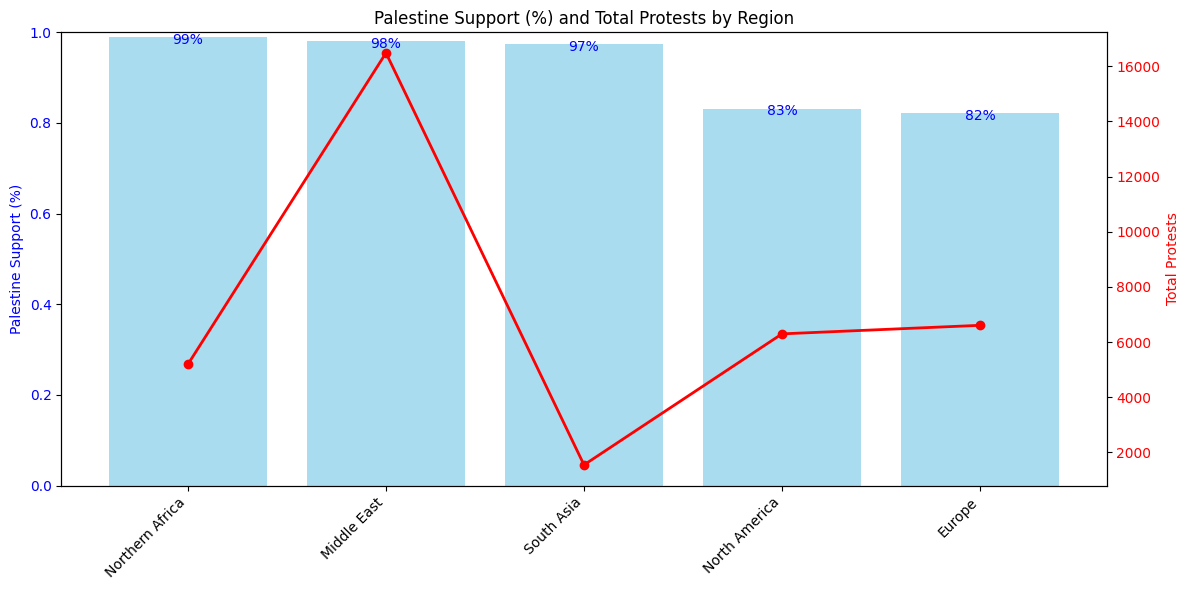

In [104]:
df_counts = annotated_protests_and_riots[annotated_protests_and_riots['conflict_related'] == 1]
df_counts['pro_israel'] = [int(x) for x in df_counts['pro_israel'] == 1]
df_counts['pro_palestine'] = [int(x) for x in df_counts['pro_palestine'] == 1]
# Suppose df_counts was built like this:
df_counts = (
    df_counts.groupby('region', as_index=False)
        .agg(total_protests=('event_id_cnty', 'count'),
             pro_palestine=('pro_palestine', 'sum'),
             pro_israel=('pro_israel', 'sum'))
)
df_counts['pct_pro_palestine'] = df_counts['pro_palestine'] / df_counts['total_protests']
df_counts['pct_pro_israel'] = df_counts['pro_israel'] / df_counts['total_protests']
df_counts

import matplotlib.pyplot as plt

# Filter out regions with fewer than 1000 total protests
df_counts_filtered = df_counts[df_counts['total_protests'] >= 1000]

# Sort the filtered DataFrame by the percentage of pro-Palestine support in descending order
df_counts_sorted = df_counts_filtered.sort_values('pct_pro_palestine', ascending=False)

# Create a figure and axis for the percentage bar plot
fig, ax1 = plt.subplots(figsize=(12,6))

# Bar plot for the percentage of pro-Palestine support
bars = ax1.bar(df_counts_sorted['region'], df_counts_sorted['pct_pro_palestine'], 
               color='skyblue', alpha=0.7, label='Palestine Support (%)')
ax1.set_ylabel('Palestine Support (%)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0, 1)  # because percentages are between 0 and 1

# Annotate each bar with its percentage value (formatted as a percent)
# Here, we move the annotation lower inside the bar by using a negative vertical offset
for bar in bars:
    height = bar.get_height()
    ax1.annotate(f'{height:.0%}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # negative offset moves the label lower (inside the bar)
                 textcoords="offset points",
                 ha='center', va='top', color='blue')

# Create a second y-axis to plot the total protests
ax2 = ax1.twinx()
ax2.plot(df_counts_sorted['region'], df_counts_sorted['total_protests'], 
         color='red', marker='o', linewidth=2, label='Total Protests')
ax2.set_ylabel('Total Protests', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Set the title and rotate the x-axis tick labels
plt.title('Palestine Support (%) and Total Protests by Region')
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()


# Zoom in to the US

In [9]:
df = annotated_protests_and_riots[annotated_protests_and_riots['country'] == 'United States']
df

,event_id_cnty,event_date,year,time_precision,disorder_type,event_type,sub_event_type,actor1,assoc_actor_1,inter1,...,tags,timestamp,conflict_related,label,not_conflict_related,pro_israel,pro_palestine,antisemite,year_month,date
243,USA76854,2025-02-13,2025,1,Demonstrations,Protests,Peaceful protest,Protesters (United States),SDS: Students for a Democratic Society; SJP: S...,Protesters,...,counter-demonstration; crowd size=around 150,1739921078,1,pro-Both,0,0,0,0,2025-02,2025-02-13
248,USA77057,2025-02-12,2025,1,Demonstrations,Protests,Peaceful protest,Protesters (United States),Latin American Group (United States); LGBTQ+ (...,Protesters,...,crowd size=no report,1739921080,1,pro-Both,0,0,0,0,2025-02,2025-02-12
253,USA77038,2025-02-11,2025,1,Demonstrations,Protests,Peaceful protest,Protesters (United States),NaN,Protesters,...,crowd size=no report,1739921080,1,pro-Palestinian antisemite,0,0,1,1,2025-02,2025-02-11
254,USA77043,2025-02-11,2025,1,Demonstrations,Protests,Peaceful protest,Protesters (United States),DEM: Democratic Party; Indivisible Movement; L...,Protesters,...,crowd size=about 65,1739921080,1,pro-Both,0,0,0,0,2025-02,2025-02-11
257,USA76918,2025-02-10,2025,1,Demonstrations,Protests,Peaceful protest,Protesters (United States),SJP: Students for Justice in Palestine; Studen...,Protesters,...,crowd size=more than 100,1739921079,1,pro-Palestinian,0,0,1,0,2025-02,2025-02-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38861,USA23758,2020-01-13,2020,1,Demonstrations,Protests,Peaceful protest,Protesters (United States),Students (United States),Protesters,...,crowd size=no report,1612546519,1,pro-Israel,0,1,0,0,2020-01,2020-01-13
38862,USA23754,2020-01-12,2020,1,Demonstrations,Protests,Peaceful protest,Protesters (United States),Jewish Group (United States),Protesters,...,crowd size=no report,1612546518,1,pro-Israel,0,1,0,0,2020-01,2020-01-12
38863,USA23369,2020-01-12,2020,1,Demonstrations,Protests,Peaceful protest,Protesters (United States),Catholic Christian Group (United States); Inte...,Protesters,...,crowd size=hundreds,1710268058,1,pro-Israel,0,1,0,0,2020-01,2020-01-12
38871,USA23742,2020-01-07,2020,1,Demonstrations,Protests,Peaceful protest,Protesters (United States),Students (United States); Jewish Group (United...,Protesters,...,crowd size=no report,1612546519,1,pro-Palestinian,0,0,1,0,2020-01,2020-01-07


In [50]:
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Ensure 'event_date' is in datetime format
df_reports['event_date'] = pd.to_datetime(df_reports['event_date'])
annotated_protests_and_riots['event_date'] = pd.to_datetime(annotated_protests_and_riots['event_date'])

# Filter data for events in the United States after October 7, 2023
df_reports_filtered = df_reports[
    (df_reports['event_date'] > pd.to_datetime('2023-10-07'))
]
annotated_protests_filtered = annotated_protests_and_riots[
    (annotated_protests_and_riots['conflict_related'] == 1) &
    (annotated_protests_and_riots['event_date'] > pd.to_datetime('2023-10-07')) &
    (annotated_protests_and_riots['country'] == 'United States')
]

# Create a 'week' column by extracting the week start date from 'event_date'
# This converts the date to a weekly period and then gets the start of that period.
df_reports_filtered['week'] = df_reports_filtered['event_date'].dt.to_period('W').apply(lambda r: r.start_time)
annotated_protests_filtered['week'] = annotated_protests_filtered['event_date'].dt.to_period('W').apply(lambda r: r.start_time)

# Aggregate fatalities by week
fatalities_by_week = df_reports_filtered.groupby('week')['fatalities'].sum().reset_index()
fatalities_by_week.columns = ['week', 'total_fatalities']

# Aggregate protest counts by week
protests_by_week = annotated_protests_filtered.groupby('week').size().reset_index(name='protest_count')

# Merge the weekly datasets and sort by week
combined_data_weekly = pd.merge(fatalities_by_week, protests_by_week, on='week', how='outer').fillna(0)
combined_data_weekly = combined_data_weekly.sort_values('week')

# Create dual-axis plot with Plotly
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add fatalities trace on the primary y-axis
fig.add_trace(
    go.Scatter(x=combined_data_weekly['week'], y=combined_data_weekly['total_fatalities'], 
               name='Fatalities', line=dict(color='red')),
    secondary_y=False
)

# Add protest count trace on the secondary y-axis
fig.add_trace(
    go.Scatter(x=combined_data_weekly['week'], y=combined_data_weekly['protest_count'], 
               name='Protest Count', line=dict(color='blue')),
    secondary_y=True
)

# Update layout and axes titles
fig.update_layout(
    title='Relationship Between Fatalities and Protest Activity Over Time (Weekly, US Only)',
    xaxis_title='Week',
    legend=dict(orientation='h', yanchor="bottom", y=1.02, xanchor="center", x=0.5)
)
fig.update_yaxes(title_text='Total Reported Fatalities', secondary_y=False, color='red')
fig.update_yaxes(title_text='Number of Protests', secondary_y=True, color='blue')

fig.show()

# Calculate the correlation between weekly fatalities and protest count
correlation = combined_data_weekly['total_fatalities'].corr(combined_data_weekly['protest_count'])
print(f"Correlation between fatalities and protest count: {correlation:.3f}")

# Compute one-week lag correlation
combined_data_weekly['fatalities_lag1'] = combined_data_weekly['total_fatalities'].shift(1)
lag_correlation = combined_data_weekly['fatalities_lag1'].corr(combined_data_weekly['protest_count'])
print(f"Correlation with 1-week lag: {lag_correlation:.3f}")


C:\Users\omerg\AppData\Local\Temp\ipykernel_167224\2009417311.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\omerg\AppData\Local\Temp\ipykernel_167224\2009417311.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Correlation between fatalities and protest count: 0.384
Correlation with 1-week lag: 0.248


In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from nltk.util import ngrams
import plotly.express as px
import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Initialize the WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Filter for pro-Israel and pro-Palestine events (assuming df is already defined)
pro_israel_notes = df[df['pro_israel'] == 1]['notes'].dropna().tolist()
pro_palestine_notes = df[df['pro_palestine'] == 1]['notes'].dropna().tolist()

# Text cleaning function using lemmatization
def clean_text(text):
    if not isinstance(text, str):
        return ""
    
    # Custom cleaning: remove specific phrase
    text = text.replace('amid the Israel-Hamas war which began in October 2023', ' ')
    
    # Remove date patterns (e.g., "on 12 october 2023,") and convert to lowercase
    text = re.sub(
        r'on\s+(\d{1,2})\s+(january|february|march|april|may|june|july|august|september|october|november|december)\s+(\d{4}),', 
        ' ', 
        text.lower()
    )
    
    # Remove punctuation and ensure text is lowercase (again for consistency)
    cleaned_text = re.sub(r'[^\w\s]', ' ', text.lower())
    
    # Tokenize the cleaned text
    tokens = word_tokenize(cleaned_text)
    
    # Apply lemmatization to normalize words (e.g., "universities" becomes "university")
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(lemmatized_tokens)

# Extract and count single words (removing short words)
all_words = []
for note in pro_israel_notes:
    words = clean_text(note).split()
    all_words.extend([word for word in words if len(word) > 3])
    
all_words_pl = []
for note in pro_palestine_notes:
    words = clean_text(note).split()
    all_words_pl.extend([word for word in words if len(word) > 3])

word_counts = Counter(all_words)
word_counts_pl = Counter(all_words_pl)

top_words = word_counts.most_common(80)
top_words_pl = word_counts_pl.most_common(80)
print(top_words)
print(top_words_pl)

# Create visualizations for pro-Israel events
fig1 = px.bar(
    x=[word for word, count in top_words],
    y=[count for word, count in top_words],
    title="Most Common Words in Pro-Israel Event Notes",
    labels={'x': 'Word', 'y': 'Frequency'},
    color_discrete_sequence=['#1f77b4'],
)
fig1.update_layout(xaxis_categoryorder='total descending')

# Create visualizations for pro-Palestine events
fig2 = px.bar(
    x=[word for word, count in top_words_pl],
    y=[count for word, count in top_words_pl],
    title="Most Common Words in Pro-Palestine Event Notes",
    labels={'x': 'Word', 'y': 'Frequency'},
    color_discrete_sequence=['#1f77b4'],
)
fig2.update_layout(xaxis_categoryorder='total descending')

# Display results
fig1.show()
fig2.show()


[('israel', 2174), ('hamas', 1135), ('jewish', 730), ('israeli', 701), ('people', 686), ('support', 542), ('member', 491), ('community', 452), ('demonstration', 441), ('with', 426), ('gathered', 397), ('hostage', 392), ('held', 382), ('rally', 375), ('october', 372), ('including', 368), ('between', 342), ('call', 341), ('attack', 341), ('protester', 316), ('against', 312), ('after', 299), ('fighting', 286), ('release', 280), ('protest', 272), ('solidarity', 268), ('demonstrator', 259), ('took', 257), ('place', 256), ('around', 240), ('york', 235), ('student', 220), ('gaza', 207), ('organized', 206), ('palestinian', 191), ('palestine', 191), ('group', 187), ('this', 175), ('wake', 172), ('renewed', 172), ('demand', 168), ('hundred', 167), ('their', 151), ('were', 150), ('university', 150), ('rallied', 147), ('they', 143), ('2023', 142), ('show', 140), ('also', 139), ('following', 138), ('demonstrated', 136), ('city', 135), ('outside', 134), ('military', 130), ('american', 128), ('anti',

In [117]:
import pandas as pd
import re
import plotly.express as px

# Define selected words for each group (customize these lists as needed)
pro_israel_selected_words = ["hostage", "university", "student", "antisemitism"]
pro_palestine_selected_words = ["intifada", 'university', 'student', "ceasefire", "occupation", 'genocide', 'celebrate']

# Ensure the 'notes' column is a string
df['notes'] = df['notes'].astype(str)

# Convert 'year_month' column to datetime (assuming format is 'yyyy-mm')
df['year_month'] = pd.to_datetime(df['year_month'], format='%Y-%m')

# Filter for protests after October 2023
filtered_df = df[df['year_month'] >= pd.to_datetime("2023-10", format='%Y-%m')]

# Split the DataFrame into pro‑Israel and pro‑Palestine protests
israel_df = filtered_df[filtered_df['pro_israel'] == 1]
palestine_df = filtered_df[filtered_df['pro_palestine'] == 1]

# Function to check if a word is present in a text (binary: 1 if present, 0 otherwise)
def word_present(text, word):
    return 1 if re.search(r'\b' + re.escape(word) + r'\b', text.lower()) else 0

# Function to compute the proportion of protests (per month) that mention each word
def compute_word_proportions(df_group, selected_words):
    counts_data = []
    # Group by 'year_month'
    for ym, group in df_group.groupby('year_month'):
        protest_count = group.shape[0]
        counts = {}
        # For each selected word, sum binary presence over all notes in the month
        for word in selected_words:
            count = group['notes'].apply(lambda note: word_present(note, word)).sum()
            # Proportion: fraction of notes (protests) where the word is mentioned
            counts[word] = count / protest_count
        counts['year_month'] = ym
        counts_data.append(counts)
    # Create DataFrame from the aggregated counts and reshape for plotting
    result_df = pd.DataFrame(counts_data).sort_values('year_month')
    melted = result_df.melt(id_vars='year_month', value_vars=selected_words,
                             var_name='word', value_name='proportion')
    return melted

# Compute proportions for pro‑Israel protests
melted_israel = compute_word_proportions(israel_df, pro_israel_selected_words)

# Compute proportions for pro‑Palestine protests
melted_palestine = compute_word_proportions(palestine_df, pro_palestine_selected_words)

# Create a line chart for pro‑Israel protests
fig_israel = px.line(melted_israel, x='year_month', y='proportion', color='word', markers=True,
                     title="Word Usage Proportion Over Time (Pro-Israel Protests)")
fig_israel.update_layout(xaxis_title="Year-Month", yaxis_title="Proportion of Protests with Word Present")

# Create a line chart for pro‑Palestine protests
fig_palestine = px.line(melted_palestine, x='year_month', y='proportion', color='word', markers=True,
                        title="Word Usage Proportion Over Time (Pro-Palestine Protests)")
fig_palestine.update_layout(xaxis_title="Year-Month", yaxis_title="Proportion of Protests with Word Present")

# Display the plots
fig_israel.show()
fig_palestine.show()


In [34]:
import pandas as pd
import plotly.express as px

# --- Step 1: Filter and prepare the data ---
# Filter for USA protests that are conflict related
df_usa = annotated_protests_and_riots[
    (annotated_protests_and_riots['conflict_related'] == 1) & 
    (annotated_protests_and_riots['country'] == "United States")
]

# Convert the pro_israel and pro_palestine columns to binary (1 if true, 0 otherwise)
df_usa['pro_israel'] = df_usa['pro_israel'].apply(lambda x: 1 if x == 1 else 0)
df_usa['pro_palestine'] = df_usa['pro_palestine'].apply(lambda x: 1 if x == 1 else 0)

# Group by state (admin1) and aggregate protest counts and the sums for each category
df_counts = (
    df_usa.groupby('admin1', as_index=False)
          .agg(total_protests=('event_id_cnty', 'count'),
               pro_palestine=('pro_palestine', 'sum'),
               pro_israel=('pro_israel', 'sum'))
)

# Calculate proportions
df_counts['pct_pro_palestine'] = df_counts['pro_palestine'] / df_counts['total_protests']
df_counts['pct_pro_israel'] = df_counts['pro_israel'] / df_counts['total_protests']

# Remove states with very few protests (adjust threshold as needed)
df_counts = df_counts[df_counts['total_protests'] >= 2]

# --- Step 2: Map full state names to state codes ---
# This mapping dictionary converts full state names to their 2-letter abbreviations.
state_abbrev = {
    "Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR",
    "California": "CA", "Colorado": "CO", "Connecticut": "CT", "Delaware": "DE",
    "Florida": "FL", "Georgia": "GA", "Hawaii": "HI", "Idaho": "ID",
    "Illinois": "IL", "Indiana": "IN", "Iowa": "IA", "Kansas": "KS",
    "Kentucky": "KY", "Louisiana": "LA", "Maine": "ME", "Maryland": "MD",
    "Massachusetts": "MA", "Michigan": "MI", "Minnesota": "MN", "Mississippi": "MS",
    "Missouri": "MO", "Montana": "MT", "Nebraska": "NE", "Nevada": "NV",
    "New Hampshire": "NH", "New Jersey": "NJ", "New Mexico": "NM", "New York": "NY",
    "North Carolina": "NC", "North Dakota": "ND", "Ohio": "OH", "Oklahoma": "OK",
    "Oregon": "OR", "Pennsylvania": "PA", "Rhode Island": "RI", "South Carolina": "SC",
    "South Dakota": "SD", "Tennessee": "TN", "Texas": "TX", "Utah": "UT",
    "Vermont": "VT", "Virginia": "VA", "Washington": "WA", "West Virginia": "WV",
    "Wisconsin": "WI", "Wyoming": "WY"
}
# Create a new column with the state abbreviations
df_counts['state_code'] = df_counts['admin1'].map(state_abbrev)

# --- Step 3: Create the choropleth maps for the USA ---

# Choropleth for Pro-Palestine protests
fig_pal = px.choropleth(
    df_counts,
    locations="state_code",
    locationmode="USA-states",
    color="pct_pro_palestine",
    hover_name="admin1",
    hover_data=["total_protests"],
    color_continuous_scale=px.colors.sequential.Viridis,
    range_color=(0, df_counts["pct_pro_palestine"].max()),
    scope="usa",
    title="Pro-Palestine Protests (Percentage by State)"
)
fig_pal.update_layout(width=1200, height=600)
fig_pal.show()

# Choropleth for Pro-Israel protests
fig_isr = px.choropleth(
    df_counts,
    locations="state_code",
    locationmode="USA-states",
    color="pct_pro_israel",
    hover_name="admin1",
    hover_data=["total_protests"],
    color_continuous_scale=px.colors.sequential.Viridis,
    range_color=(0, df_counts["pct_pro_israel"].max()),
    scope="usa",
    title="Pro-Israel Protests (Percentage by State)"
)
fig_isr.update_layout(width=1200, height=600)
fig_isr.show()

C:\Users\omerg\AppData\Local\Temp\ipykernel_167224\2052569936.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\omerg\AppData\Local\Temp\ipykernel_167224\2052569936.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

